In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, f1_score
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
from PIL import Image
import pandas as pd
from tqdm import tqdm
import os
import warnings
from collections import Counter
import copy
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

class DDIDataset(Dataset):
    """
    Custom Dataset for DDI images
    """
    def __init__(self, csv_file, image_dir, transform=None,
                 augment_minority=False, minority_group=None):

        self.df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.augment_minority = augment_minority
        self.minority_group = minority_group

        print(f"Loaded {len(self.df)} samples from {csv_file}")
        print(f"Columns in dataset: {list(self.df.columns)}")

        # augmentation transform for minority group
        if augment_minority:
            self.extra_augment = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.7),
                transforms.RandomVerticalFlip(p=0.3),
                transforms.RandomRotation(30),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
                transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.85, 1.15)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_filename = row['DDI_file']

        img_path = os.path.join(self.image_dir, img_filename)

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = Image.new('RGB', (224, 224), color='black')

        # Get sensitive attribute
        sensitive = int(row['sensitive_binary'])


        # Apply augmentation
        if self.augment_minority and sensitive == self.minority_group and self.transform:
            image = self.extra_augment(image)
        elif self.transform:
            image = self.transform(image)

        label = int(row['malignant'])

        return image, label, sensitive


class WeightedDDIDataset(DDIDataset):
    """Dataset that returns sample weights for reweighting"""
    def __init__(self, *args, sample_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.sample_weights = sample_weights

    def __getitem__(self, idx):
        image, label, sensitive = super().__getitem__(idx)
        weight = self.sample_weights[idx] if self.sample_weights is not None else 1.0
        return image, label, sensitive, weight

In [2]:
class FairnessAwareLoss(nn.Module):
    """
    Cross-entropy + fairness penalty (Demographic Parity on predicted probabilities)
    """
    def __init__(self, base_loss=None, lambda_fair=0.1):
        super().__init__()
        self.base_loss = base_loss if base_loss is not None else nn.CrossEntropyLoss()
        self.lambda_fair = lambda_fair

    def forward(self, outputs, labels, sensitive):
        ce_loss = self.base_loss(outputs, labels)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        s0 = (sensitive == 0)
        s1 = (sensitive == 1)

        if s0.any() and s1.any():
            pos_rate_0 = probs[s0].mean()
            pos_rate_1 = probs[s1].mean()
            dp_diff = torch.abs(pos_rate_0 - pos_rate_1)
        else:
            dp_diff = torch.tensor(0.0, device=outputs.device)

        loss = ce_loss + self.lambda_fair * dp_diff
        return loss

In [3]:
class AdversarialDebiasing(nn.Module):
    """
    Adversarial Debiasing for Demographic Parity
    """
    def __init__(self, classifier, num_classes=2, num_sensitive=2, hidden_dim=32):
        super().__init__()
        self.classifier = classifier
        self.num_classes = num_classes
        self.num_sensitive = num_sensitive

        self.adversary = nn.Sequential(
            nn.Linear(num_classes, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_sensitive)
        )

    def forward(self, x):
        return self.classifier(x)

    def forward_adversary(self, classifier_output):
        return self.adversary(classifier_output.detach())

In [4]:
def get_transforms(input_size=224):
    """Get data transforms"""
    # Basic training transform
    train_transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform


def get_model(model_name='resnet34', num_classes=2, pretrained=True):
    """Load CNN model"""
    if model_name == 'resnet34':
        model = models.resnet34(pretrained=pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=pretrained)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'mobilenetv2':
        model = models.mobilenet_v2(pretrained=pretrained)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    else:
        raise ValueError(f"Model {model_name} not supported")

    return model


def calculate_sample_weights(df, sensitive_col='sensitive_binary', label_col='malignant'):
    """Calculate sample weights for reweighting scheme"""
    group_counts = df.groupby([sensitive_col, label_col]).size()
    total_samples = len(df)

    weights = []
    for idx, row in df.iterrows():
        sensitive = row[sensitive_col]
        label = row[label_col]
        group_size = group_counts.get((sensitive, label), 1)
        weight = total_samples / (len(group_counts) * group_size)
        weights.append(weight)

    weights = np.array(weights)
    weights = weights / weights.mean()

    return weights


def create_balanced_sampler(df, sensitive_col='sensitive_binary', label_col='malignant'):
    """Create a weighted sampler for re-sampling"""
    group_labels = df[sensitive_col].astype(str) + '_' + df[label_col].astype(str)
    class_counts = Counter(group_labels)
    weights = [1.0 / class_counts[label] for label in group_labels]
    sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)
    return sampler

In [5]:
def train_epoch(model, dataloader, criterion, optimizer, device, use_sample_weights=False):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for batch in tqdm(dataloader, desc="Training"):
        if use_sample_weights:
            images, labels, _, weights = batch
            weights = weights.to(device)
        else:
            images, labels, _ = batch
            weights = None

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        if use_sample_weights and weights is not None:
            loss = criterion(outputs, labels)
            loss = (loss * weights).mean()
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc


def train_epoch_with_fairness_loss(model, dataloader, fairness_criterion, optimizer, device):
    """Train for one epoch using FairnessAwareLoss"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for batch in tqdm(dataloader, desc="Training with Fairness Loss"):
        if len(batch) == 4:
            images, labels, sensitive, _ = batch
        else:
            images, labels, sensitive = batch

        images = images.to(device)
        labels = labels.to(device)
        sensitive = sensitive.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = fairness_criterion(outputs, labels, sensitive)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc


def train_epoch_adversarial(model, dataloader, classifier_criterion, adversary_criterion,
                           classifier_optimizer, adversary_optimizer, device,
                           lambda_adv=1.0, adversary_steps=3):
    """Train for one epoch using adversarial debiasing"""
    model.train()
    running_total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch in tqdm(dataloader, desc="Training (Adversarial)"):
        if len(batch) == 4:
            images, labels, sensitive, _ = batch
        else:
            images, labels, sensitive = batch

        images = images.to(device)
        labels = labels.to(device)
        sensitive = sensitive.to(device)

        # Train Adversary
        for _ in range(adversary_steps):
            adversary_optimizer.zero_grad()
            classifier_outputs = model(images)
            adversary_outputs = model.forward_adversary(classifier_outputs)
            adv_loss = adversary_criterion(adversary_outputs, sensitive)
            adv_loss.backward()
            adversary_optimizer.step()

        # Train Classifier
        classifier_optimizer.zero_grad()
        classifier_outputs = model(images)
        clf_loss = classifier_criterion(classifier_outputs, labels)
        adversary_outputs = model.adversary(classifier_outputs)
        uniform_target = torch.ones_like(adversary_outputs) / model.num_sensitive
        adv_confusion_loss = nn.functional.kl_div(
            nn.functional.log_softmax(adversary_outputs, dim=1),
            uniform_target,
            reduction='batchmean'
        )
        total_loss = clf_loss - lambda_adv * adv_confusion_loss
        total_loss.backward()
        classifier_optimizer.step()

        running_total_loss += total_loss.item() * images.size(0)

        _, preds = torch.max(classifier_outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_total_loss = running_total_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_total_loss, epoch_acc

In [6]:
def evaluate(model, dataloader, criterion, device, return_probabilities=True):
    """Evaluate model"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_sensitive = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            if len(batch) == 4:
                images, labels, sensitive, _ = batch
            else:
                images, labels, sensitive = batch

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            if loss.dim() > 0:
                loss = loss.mean()

            running_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_sensitive.extend(sensitive.cpu().numpy())
            if return_probabilities:
                all_probs.extend(probs[:, 1].cpu().numpy() if probs.shape[1] > 1 else probs[:, 0].cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels), np.array(all_sensitive), np.array(all_probs)


In [7]:
def calibrate_thresholds(labels, probabilities, sensitive_attrs, target_metric='equalized_odds'):
    """Find optimal thresholds per group to achieve fairness"""
    sensitive_values = np.unique(sensitive_attrs)
    thresholds = {}

    if target_metric == 'equalized_odds':
        for s in sensitive_values:
            mask = sensitive_attrs == s
            fpr, tpr, thresh = roc_curve(labels[mask], probabilities[mask])
            idx = np.argmax(tpr - fpr)
            thresholds[s] = thresh[idx]

    elif target_metric == 'demographic_parity':
        target_positive_rate = np.mean(labels)

        for s in sensitive_values:
            mask = sensitive_attrs == s
            thresholds_to_try = np.linspace(0, 1, 100)
            best_threshold = 0.5
            best_diff = float('inf')

            for thresh in thresholds_to_try:
                preds = (probabilities[mask] >= thresh).astype(int)
                pos_rate = np.mean(preds)
                diff = abs(pos_rate - target_positive_rate)
                if diff < best_diff:
                    best_diff = diff
                    best_threshold = thresh

            thresholds[s] = best_threshold

    return thresholds


def apply_calibrated_thresholds(probabilities, sensitive_attrs, thresholds):
    """Apply group-specific thresholds to predictions"""
    predictions = np.zeros_like(probabilities, dtype=int)

    for s, thresh in thresholds.items():
        mask = sensitive_attrs == s
        predictions[mask] = (probabilities[mask] >= thresh).astype(int)

    return predictions

In [8]:
def calculate_demographic_parity(predictions, sensitive_attrs):
    """Calculate Demographic Parity Difference"""
    sensitive_values = np.unique(sensitive_attrs)
    positive_rates = {}

    for s in sensitive_values:
        mask = sensitive_attrs == s
        positive_rate = np.mean(predictions[mask] == 1)
        positive_rates[s] = positive_rate

    dp_diff = abs(positive_rates[sensitive_values[0]] - positive_rates[sensitive_values[1]])

    return dp_diff


def calculate_equalized_odds(predictions, labels, sensitive_attrs):
    """Calculate Equalized Odds Difference"""
    sensitive_values = np.unique(sensitive_attrs)
    tpr_by_group = {}
    fpr_by_group = {}

    for s in sensitive_values:
        mask = sensitive_attrs == s

        y_true_pos = labels[mask] == 1
        if np.sum(y_true_pos) > 0:
            tpr = np.mean(predictions[mask][y_true_pos] == 1)
        else:
            tpr = 0.0
        tpr_by_group[s] = tpr

        y_true_neg = labels[mask] == 0
        if np.sum(y_true_neg) > 0:
            fpr = np.mean(predictions[mask][y_true_neg] == 1)
        else:
            fpr = 0.0
        fpr_by_group[s] = fpr

    tpr_diff = abs(tpr_by_group[sensitive_values[0]] - tpr_by_group[sensitive_values[1]])
    fpr_diff = abs(fpr_by_group[sensitive_values[0]] - fpr_by_group[sensitive_values[1]])
    eo_diff = max(tpr_diff, fpr_diff)

    return eo_diff


def bootstrap_metric(predictions, labels, sensitive_attrs, metric_func, n_iterations=1000, confidence_level=0.95, random_state=42):
    """Perform bootstrap resampling to estimate confidence intervals"""
    np.random.seed(random_state)
    n_samples = len(predictions)
    bootstrap_metrics = []

    for _ in range(n_iterations):
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        boot_preds = predictions[indices]
        boot_labels = labels[indices]
        boot_sensitive = sensitive_attrs[indices]
        metric_value = metric_func(boot_preds, boot_labels, boot_sensitive)
        bootstrap_metrics.append(metric_value)

    bootstrap_metrics = np.array(bootstrap_metrics)
    alpha = 1 - confidence_level
    ci_lower = np.percentile(bootstrap_metrics, 100 * alpha / 2)
    ci_upper = np.percentile(bootstrap_metrics, 100 * (1 - alpha / 2))

    return {
        'mean': np.mean(bootstrap_metrics),
        'std': np.std(bootstrap_metrics),
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'samples': bootstrap_metrics
    }


def statistical_comparison(baseline_preds, baseline_labels, baseline_sensitive,
                          treatment_preds, treatment_labels, treatment_sensitive,
                          method_name, n_bootstrap=1000):
    """Perform statistical comparison between baseline and treatment"""
    print(f"\n{'='*60}")
    print(f"Statistical Comparison: BASELINE vs {method_name}")
    print(f"{'='*60}")

    def dp_metric(preds, labels, sensitive):
        return calculate_demographic_parity(preds, sensitive)

    def eo_metric(preds, labels, sensitive):
        return calculate_equalized_odds(preds, labels, sensitive)

    # Bootstrap for Demographic Parity
    print("\n1. Demographic Parity Gap:")
    baseline_dp_boot = bootstrap_metric(baseline_preds, baseline_labels, baseline_sensitive,
                                       dp_metric, n_iterations=n_bootstrap)
    treatment_dp_boot = bootstrap_metric(treatment_preds, treatment_labels, treatment_sensitive,
                                        dp_metric, n_iterations=n_bootstrap)

    print(f"   Baseline:  {baseline_dp_boot['mean']:.4f} (95% CI: [{baseline_dp_boot['ci_lower']:.4f}, {baseline_dp_boot['ci_upper']:.4f}])")
    print(f"   {method_name}: {treatment_dp_boot['mean']:.4f} (95% CI: [{treatment_dp_boot['ci_lower']:.4f}, {treatment_dp_boot['ci_upper']:.4f}])")

    dp_improvement = baseline_dp_boot['mean'] - treatment_dp_boot['mean']
    print(f"   Improvement: {dp_improvement:.4f}")

    t_stat, p_value_dp = ttest_ind(baseline_dp_boot['samples'], treatment_dp_boot['samples'])
    print(f"   t-test p-value: {p_value_dp:.4f} {'***' if p_value_dp < 0.001 else '**' if p_value_dp < 0.01 else '*' if p_value_dp < 0.05 else 'ns'}")

    # Bootstrap for Equalized Odds
    print("\n2. Equalized Odds Gap:")
    baseline_eo_boot = bootstrap_metric(baseline_preds, baseline_labels, baseline_sensitive,
                                       eo_metric, n_iterations=n_bootstrap)
    treatment_eo_boot = bootstrap_metric(treatment_preds, treatment_labels, treatment_sensitive,
                                        eo_metric, n_iterations=n_bootstrap)

    print(f"   Baseline:  {baseline_eo_boot['mean']:.4f} (95% CI: [{baseline_eo_boot['ci_lower']:.4f}, {baseline_eo_boot['ci_upper']:.4f}])")
    print(f"   {method_name}: {treatment_eo_boot['mean']:.4f} (95% CI: [{treatment_eo_boot['ci_lower']:.4f}, {treatment_eo_boot['ci_upper']:.4f}])")

    eo_improvement = baseline_eo_boot['mean'] - treatment_eo_boot['mean']
    print(f"   Improvement: {eo_improvement:.4f}")

    t_stat, p_value_eo = ttest_ind(baseline_eo_boot['samples'], treatment_eo_boot['samples'])
    print(f"   t-test p-value: {p_value_eo:.4f} {'***' if p_value_eo < 0.001 else '**' if p_value_eo < 0.01 else '*' if p_value_eo < 0.05 else 'ns'}")

    print("\n   Significance: *** p<0.001, ** p<0.01, * p<0.05, ns p>=0.05")

    return {
        'method': method_name,
        'dp_improvement': dp_improvement,
        'dp_p_value': p_value_dp,
        'dp_significant': p_value_dp < 0.05,
        'eo_improvement': eo_improvement,
        'eo_p_value': p_value_eo,
        'eo_significant': p_value_eo < 0.05,
        'baseline_dp_ci': f"[{baseline_dp_boot['ci_lower']:.4f}, {baseline_dp_boot['ci_upper']:.4f}]",
        'treatment_dp_ci': f"[{treatment_dp_boot['ci_lower']:.4f}, {treatment_dp_boot['ci_upper']:.4f}]",
        'baseline_eo_ci': f"[{baseline_eo_boot['ci_lower']:.4f}, {baseline_eo_boot['ci_upper']:.4f}]",
        'treatment_eo_ci': f"[{treatment_eo_boot['ci_lower']:.4f}, {treatment_eo_boot['ci_upper']:.4f}]"
    }


def print_fairness_metrics(name, predictions, labels, sensitive_attrs, probabilities=None):
    """Print fairness metrics"""
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")

    acc = accuracy_score(labels, predictions)
    print(f"Accuracy: {acc:.4f}")

    f1 = f1_score(labels, predictions, average='binary', zero_division=0)
    print(f"F1 Score: {f1:.4f}")

    if probabilities is not None:
        try:
            auc = roc_auc_score(labels, probabilities)
            print(f"AUC-ROC: {auc:.4f}")
        except:
            pass

    dp_gap = calculate_demographic_parity(predictions, sensitive_attrs)
    print(f"DP Gap: {dp_gap:.4f}")

    eo_gap = calculate_equalized_odds(predictions, labels, sensitive_attrs)
    print(f"EO Gap: {eo_gap:.4f}")

    return {
        'accuracy': acc,
        'f1': f1,
        'dp_gap': dp_gap,
        'eo_gap': eo_gap
    }

In [9]:
def train_and_evaluate(model_name, train_loader, val_loader, test_loader,
                      method_name, num_classes=2, num_epochs=20, lr=0.0001,
                      device='cuda', use_sample_weights=False):
    """Train and evaluate a model"""
    print(f"\n{'='*80}")
    print(f"Training {model_name.upper()} - {method_name}")
    print(f"{'='*80}")

    model = get_model(model_name, num_classes=num_classes, pretrained=True)
    model = model.to(device)

    if use_sample_weights:
        train_criterion = nn.CrossEntropyLoss(reduction='none')
    else:
        train_criterion = nn.CrossEntropyLoss()

    eval_criterion = nn.CrossEntropyLoss(reduction='mean')

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    best_val_acc = 0.0
    best_model_state = None
    patience = 0
    patience_limit = 5

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss, train_acc = train_epoch(model, train_loader, train_criterion, optimizer, device, use_sample_weights)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

        val_loss, val_acc, _, _, _, _ = evaluate(model, val_loader, eval_criterion, device)
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience = 0
        else:
            patience += 1

        if patience >= patience_limit:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(best_model_state)

    _, test_acc, test_preds, test_labels, test_sensitive, test_probs = evaluate(
        model, test_loader, eval_criterion, device
    )

    results = print_fairness_metrics(
        f"Test Results - {model_name.upper()} - {method_name}",
        test_preds, test_labels, test_sensitive, test_probs
    )

    results['model'] = model_name
    results['method'] = method_name

    return model, results, test_preds, test_labels, test_sensitive


def train_and_evaluate_with_fairness_loss(model_name, train_loader, val_loader, test_loader,
                                         method_name, num_classes=2, num_epochs=20, lr=0.0001,
                                         device='cuda', lambda_fair=0.1):
    """Train and evaluate using FairnessAwareLoss"""
    print(f"\n{'='*80}")
    print(f"Training {model_name.upper()} - {method_name} (lambda={lambda_fair})")
    print(f"{'='*80}")

    model = get_model(model_name, num_classes=num_classes, pretrained=True)
    model = model.to(device)

    fairness_criterion = FairnessAwareLoss(lambda_fair=lambda_fair)
    eval_criterion = nn.CrossEntropyLoss(reduction='mean')

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    best_val_acc = 0.0
    best_model_state = None
    patience = 0
    patience_limit = 5

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss, train_acc = train_epoch_with_fairness_loss(
            model, train_loader, fairness_criterion, optimizer, device
        )
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

        val_loss, val_acc, _, _, _, _ = evaluate(model, val_loader, eval_criterion, device)
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience = 0
        else:
            patience += 1

        if patience >= patience_limit:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(best_model_state)

    _, test_acc, test_preds, test_labels, test_sensitive, test_probs = evaluate(
        model, test_loader, eval_criterion, device
    )

    results = print_fairness_metrics(
        f"Test Results - {model_name.upper()} - {method_name}",
        test_preds, test_labels, test_sensitive, test_probs
    )

    results['model'] = model_name
    results['method'] = method_name
    results['lambda_fair'] = lambda_fair

    return model, results, test_preds, test_labels, test_sensitive


def train_and_evaluate_adversarial(model_name, train_loader, val_loader, test_loader,
                                   method_name, num_classes=2, num_epochs=20, lr=0.0001,
                                   device='cuda', lambda_adv=1.0, adversary_steps=3):
    """Train and evaluate using adversarial debiasing"""
    print(f"\n{'='*80}")
    print(f"Training {model_name.upper()} - {method_name} (lambda_adv={lambda_adv})")
    print(f"{'='*80}")

    base_classifier = get_model(model_name, num_classes=num_classes, pretrained=True)
    model = AdversarialDebiasing(base_classifier, num_classes=num_classes, num_sensitive=2)
    model = model.to(device)

    classifier_criterion = nn.CrossEntropyLoss()
    adversary_criterion = nn.CrossEntropyLoss()
    eval_criterion = nn.CrossEntropyLoss(reduction='mean')

    classifier_params = model.classifier.parameters()
    adversary_params = model.adversary.parameters()

    classifier_optimizer = optim.Adam(classifier_params, lr=lr)
    adversary_optimizer = optim.Adam(adversary_params, lr=lr * 2)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(classifier_optimizer, mode='min', patience=3, factor=0.5)

    best_val_acc = 0.0
    best_model_state = None
    patience = 0
    patience_limit = 5

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss, train_acc = train_epoch_adversarial(
            model, train_loader, classifier_criterion, adversary_criterion,
            classifier_optimizer, adversary_optimizer, device, lambda_adv, adversary_steps
        )
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

        val_loss, val_acc, _, _, _, _ = evaluate(model, val_loader, eval_criterion, device)
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience = 0
        else:
            patience += 1

        if patience >= patience_limit:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(best_model_state)

    _, test_acc, test_preds, test_labels, test_sensitive, test_probs = evaluate(
        model, test_loader, eval_criterion, device
    )

    results = print_fairness_metrics(
        f"Test Results - {model_name.upper()} - {method_name}",
        test_preds, test_labels, test_sensitive, test_probs
    )

    results['model'] = model_name
    results['method'] = method_name
    results['lambda_adv'] = lambda_adv

    return model, results, test_preds, test_labels, test_sensitive

In [10]:
def split_data(csv_file, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
    """Split data into train/val/test"""
    from sklearn.model_selection import train_test_split

    df = pd.read_csv(csv_file)

    print(f"Original dataset: {len(df)} samples")

    train_df, temp_df = train_test_split(df, test_size=(1-train_ratio), stratify=df['malignant'], random_state=random_state)
    val_ratio_adj = val_ratio / (val_ratio + test_ratio)
    val_df, test_df = train_test_split(temp_df, test_size=(1-val_ratio_adj), stratify=temp_df['malignant'], random_state=random_state)

    train_df.to_csv('train_split.csv', index=False)
    val_df.to_csv('val_split.csv', index=False)
    test_df.to_csv('test_split.csv', index=False)

    print(f"\nDataset split: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

    return 'train_split.csv', 'val_split.csv', 'test_split.csv'


In [ ]:
def main():
    # CONFIGURATION
    IMAGE_DIR = '/content/drive/MyDrive/ELEC 509/Final Project/DDI/images'
    CSV_FILE = '/content/drive/MyDrive/ELEC 509/Final Project/DDI/skin_diagnose_grouped.csv'

    BATCH_SIZE = 32
    NUM_EPOCHS = 30
    LEARNING_RATE = 0.0001
    NUM_CLASSES = 2
    MODELS = ['resnet34', 'densenet121', 'mobilenetv2']
    LAMBDA_FAIR = 0.3
    LAMBDA_ADV = 1.5
    ADV_STEPS = 5
    N_BOOTSTRAP = 1000


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Split data
    train_csv, val_csv, test_csv = split_data(CSV_FILE)
    train_transform, val_transform = get_transforms()

    # Filter and process data
    df = pd.read_csv(train_csv)

    # Filter: skin_tone 12, 34, and 56
    print(f"\nOriginal training dataset size: {len(df)}")
    df = df[df['skin_tone'].isin([12, 34, 56])].reset_index(drop=True)
    print(f"Filtered dataset size (skin_tone 12, 34, 56): {len(df)}")

    # Define skin tone grouping: 12 and 34 = majority (0), 56 = minority (1)
    def assign_sensitive_group(skin_tone):
        if skin_tone in [12, 34]:
            return 0  # Majority group
        elif skin_tone == 56:
            return 1  # Minority group
        else:
            raise ValueError(f"Unknown skin tone")

    df['sensitive_binary'] = df['skin_tone'].apply(assign_sensitive_group)
    minority_group = 1  # 56 is the minority group

    # Save filtered splits
    df.to_csv('train_split.csv', index=False)

    # Also filter validation and test sets
    val_df = pd.read_csv(val_csv)
    val_df = val_df[val_df['skin_tone'].isin([12, 34, 56])].reset_index(drop=True)
    val_df['sensitive_binary'] = val_df['skin_tone'].apply(assign_sensitive_group)
    val_df.to_csv('val_split.csv', index=False)

    test_df = pd.read_csv(test_csv)
    test_df = test_df[test_df['skin_tone'].isin([12, 34, 56])].reset_index(drop=True)
    test_df['sensitive_binary'] = test_df['skin_tone'].apply(assign_sensitive_group)
    test_df.to_csv('test_split.csv', index=False)

    print(f"\nSkin tone grouping:")
    print(f"  Majority group (0): skin_tone = 12 and 34 - {(df['sensitive_binary'] == 0).sum()} samples")
    print(f"    - skin_tone 12: {(df['skin_tone'] == 12).sum()} samples")
    print(f"    - skin_tone 34: {(df['skin_tone'] == 34).sum()} samples")
    print(f"  Minority group (1): skin_tone = 56 - {(df['sensitive_binary'] == 1).sum()} samples")
    print(f"Minority group (for augmentation): {minority_group}")

    all_results = []
    all_predictions = {}
    statistical_results = []

    for model_name in MODELS:
        print(f"\n{'#'*80}")
        print(f"MODEL: {model_name.upper()}")
        print(f"{'#'*80}")

        # BASELINE
        print("\n>>> BASELINE (No Fairness Intervention)")
        train_dataset = DDIDataset(train_csv, IMAGE_DIR, transform=train_transform)
        val_dataset = DDIDataset(val_csv, IMAGE_DIR, transform=val_transform)
        test_dataset = DDIDataset(test_csv, IMAGE_DIR, transform=val_transform)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

        model_baseline, results_baseline, preds_baseline, labels_baseline, sensitive_baseline = train_and_evaluate(
            model_name, train_loader, val_loader, test_loader, "BASELINE",
            num_classes=NUM_CLASSES, num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, device=device
        )
        all_results.append(results_baseline)

        baseline_key = f"{model_name}_BASELINE"
        all_predictions[baseline_key] = {
            'preds': preds_baseline,
            'labels': labels_baseline,
            'sensitive': sensitive_baseline
        }

        # DATA AUGMENTATION
        print("\n>>> DATA AUGMENTATION")
        train_dataset_aug = DDIDataset(train_csv, IMAGE_DIR, transform=train_transform,
                                      augment_minority=True, minority_group=minority_group)
        train_loader_aug = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

        model_aug, results_aug, preds_aug, labels_aug, sensitive_aug = train_and_evaluate(
            model_name, train_loader_aug, val_loader, test_loader, "DATA_AUGMENTATION",
            num_classes=NUM_CLASSES, num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, device=device
        )
        all_results.append(results_aug)

        all_predictions[f"{model_name}_DATA_AUGMENTATION"] = {
            'preds': preds_aug,
            'labels': labels_aug,
            'sensitive': sensitive_aug
        }

        # RE-SAMPLING
        print("\n>>> RE-SAMPLING")
        sampler = create_balanced_sampler(df)
        train_loader_resample = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4)

        model_resample, results_resample, preds_resample, labels_resample, sensitive_resample = train_and_evaluate(
            model_name, train_loader_resample, val_loader, test_loader, "RE_SAMPLING",
            num_classes=NUM_CLASSES, num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, device=device
        )
        all_results.append(results_resample)

        all_predictions[f"{model_name}_RE_SAMPLING"] = {
            'preds': preds_resample,
            'labels': labels_resample,
            'sensitive': sensitive_resample
        }

        # REWEIGHTING
        print("\n>>> REWEIGHTING")
        sample_weights = calculate_sample_weights(df)
        train_dataset_weighted = WeightedDDIDataset(train_csv, IMAGE_DIR, transform=train_transform,
                                                    sample_weights=sample_weights)
        train_loader_weighted = DataLoader(train_dataset_weighted, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

        model_weighted, results_weighted, preds_weighted, labels_weighted, sensitive_weighted = train_and_evaluate(
            model_name, train_loader_weighted, val_loader, test_loader, "REWEIGHTING",
            num_classes=NUM_CLASSES, num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, device=device, use_sample_weights=True
        )
        all_results.append(results_weighted)

        all_predictions[f"{model_name}_REWEIGHTING"] = {
            'preds': preds_weighted,
            'labels': labels_weighted,
            'sensitive': sensitive_weighted
        }

        # FAIRNESS-AWARE LOSS
        print("\n>>> FAIRNESS-AWARE LOSS")
        model_fairloss, results_fairloss, preds_fairloss, labels_fairloss, sensitive_fairloss = train_and_evaluate_with_fairness_loss(
            model_name, train_loader, val_loader, test_loader, "FAIRNESS_AWARE_LOSS",
            num_classes=NUM_CLASSES, num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, device=device, lambda_fair=LAMBDA_FAIR
        )
        all_results.append(results_fairloss)

        all_predictions[f"{model_name}_FAIRNESS_AWARE_LOSS"] = {
            'preds': preds_fairloss,
            'labels': labels_fairloss,
            'sensitive': sensitive_fairloss
        }

        # ADVERSARIAL DEBIASING
        print("\n>>> ADVERSARIAL DEBIASING")
        model_adv, results_adv, preds_adv, labels_adv, sensitive_adv = train_and_evaluate_adversarial(
            model_name, train_loader, val_loader, test_loader, "ADVERSARIAL_DEBIASING",
            num_classes=NUM_CLASSES, num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, device=device,
            lambda_adv=LAMBDA_ADV, adversary_steps=ADV_STEPS
        )
        all_results.append(results_adv)

        all_predictions[f"{model_name}_ADVERSARIAL_DEBIASING"] = {
            'preds': preds_adv,
            'labels': labels_adv,
            'sensitive': sensitive_adv
        }

        # THRESHOLD CALIBRATION
        print("\n>>> THRESHOLD CALIBRATION")
        # Re-run evaluation to get probabilities
        _, _, _, _, _, probs_baseline = evaluate(model_baseline, test_loader, nn.CrossEntropyLoss(reduction='mean'), device)

        thresholds = calibrate_thresholds(labels_baseline, probs_baseline, sensitive_baseline,
                                         target_metric='equalized_odds')
        print(f"Calibrated thresholds: {thresholds}")

        preds_calibrated = apply_calibrated_thresholds(probs_baseline, sensitive_baseline, thresholds)

        results_calibrated = print_fairness_metrics(
            f"Test Results - {model_name.upper()} - THRESHOLD_CALIBRATION",
            preds_calibrated, labels_baseline, sensitive_baseline, probs_baseline
        )
        results_calibrated['model'] = model_name
        results_calibrated['method'] = 'THRESHOLD_CALIBRATION'
        all_results.append(results_calibrated)

        all_predictions[f"{model_name}_THRESHOLD_CALIBRATION"] = {
            'preds': preds_calibrated,
            'labels': labels_baseline,
            'sensitive': sensitive_baseline
        }

    # STATISTICAL TESTING
    print("\n\n" + "="*100)
    print("STATISTICAL TESTING - Bootstrap Comparison with Baseline")
    print("="*100)

    for model_name in MODELS:
        print(f"\n{'*'*80}")
        print(f"MODEL: {model_name.upper()}")
        print(f"{'*'*80}")

        baseline_key = f"{model_name}_BASELINE"
        baseline_data = all_predictions[baseline_key]

        methods = ['DATA_AUGMENTATION', 'RE_SAMPLING', 'REWEIGHTING',
                  'FAIRNESS_AWARE_LOSS', 'ADVERSARIAL_DEBIASING', 'THRESHOLD_CALIBRATION']

        for method in methods:
            treatment_key = f"{model_name}_{method}"
            treatment_data = all_predictions[treatment_key]

            stat_result = statistical_comparison(
                baseline_data['preds'], baseline_data['labels'], baseline_data['sensitive'],
                treatment_data['preds'], treatment_data['labels'], treatment_data['sensitive'],
                method, n_bootstrap=N_BOOTSTRAP
            )
            stat_result['model'] = model_name
            statistical_results.append(stat_result)

    # FINAL COMPARISON
    print("\n\n" + "="*100)
    print("FINAL COMPARISON - ALL METHODS")
    print("="*100)

    results_df = pd.DataFrame(all_results)
    results_df = results_df[['model', 'method', 'accuracy', 'f1', 'dp_gap', 'eo_gap']]
    results_df = results_df.round(4)

    print("\n", results_df.to_string(index=False))

    results_df.to_csv('/content/drive/MyDrive/ELEC 509/Final Project/ddi_fairness_comparison_results_ddi.csv', index=False)
    print("\n" + "="*100)
    print("Results saved to 'fairness_comparison_results_ddi.csv'")
    print("="*100)

    # STATISTICAL TESTING SUMMARY
    print("\n\n" + "="*100)
    print("STATISTICAL TESTING SUMMARY")
    print("="*100)

    stat_df = pd.DataFrame(statistical_results)
    stat_df = stat_df[['model', 'method', 'dp_improvement', 'dp_p_value', 'dp_significant',
                       'eo_improvement', 'eo_p_value', 'eo_significant']]
    stat_df = stat_df.round(4)

    print("\n", stat_df.to_string(index=False))

    stat_df.to_csv('/content/drive/MyDrive/ELEC 509/Final Project/ddi_statistical_comparison_results_ddi.csv', index=False)
    print("\n" + "="*100)
    print("Statistical results saved to 'statistical_comparison_results_ddi.csv'")
    print("="*100)


if __name__ == "__main__":
    main()

Using device: cuda
Original dataset: 656 samples

Dataset split: Train=459, Val=98, Test=99

Original training dataset size: 459
Filtered dataset size (skin_tone 12, 34, 56): 459

Skin tone grouping:
  Majority group (0): skin_tone = 12 and 34 - 312 samples
    - skin_tone 12: 148 samples
    - skin_tone 34: 164 samples
  Minority group (1): skin_tone = 56 - 147 samples
Minority group (for augmentation): 1

################################################################################
MODEL: RESNET34
################################################################################

>>> BASELINE (No Fairness Intervention)
Loaded 459 samples from train_split.csv
Columns in dataset: ['Unnamed: 0', 'DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'sensitive_binary']
Loaded 98 samples from val_split.csv
Columns in dataset: ['Unnamed: 0', 'DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'sensitive_binary']
Loaded 99 samples from test_split.csv
Columns in dataset: ['Unnam

Training: 100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


Train Loss: 0.8558, Train Acc: 0.4749


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Val Loss: 0.5535, Val Acc: 0.8061

Epoch 2/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


Train Loss: 0.1627, Train Acc: 0.9564


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


Val Loss: 0.5441, Val Acc: 0.7857

Epoch 3/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


Train Loss: 0.0485, Train Acc: 0.9956


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


Val Loss: 0.5984, Val Acc: 0.7551

Epoch 4/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


Train Loss: 0.0236, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]


Val Loss: 0.6679, Val Acc: 0.7653

Epoch 5/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


Train Loss: 0.0081, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


Val Loss: 0.7349, Val Acc: 0.7755

Epoch 6/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


Train Loss: 0.0050, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Val Loss: 0.7619, Val Acc: 0.7653
Early stopping at epoch 6


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]



Test Results - RESNET34 - BASELINE
Accuracy: 0.7677
F1 Score: 0.3784
AUC-ROC: 0.7603
DP Gap: 0.2037
EO Gap: 0.6090

>>> DATA AUGMENTATION
Loaded 459 samples from train_split.csv
Columns in dataset: ['Unnamed: 0', 'DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'sensitive_binary']

Training RESNET34 - DATA_AUGMENTATION

Epoch 1/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


Train Loss: 0.5898, Train Acc: 0.6950


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


Val Loss: 0.5080, Val Acc: 0.7857

Epoch 2/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


Train Loss: 0.2609, Train Acc: 0.8998


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Val Loss: 0.6166, Val Acc: 0.7755

Epoch 3/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


Train Loss: 0.1315, Train Acc: 0.9586


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


Val Loss: 0.8530, Val Acc: 0.7857

Epoch 4/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


Train Loss: 0.0846, Train Acc: 0.9695


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


Val Loss: 0.7871, Val Acc: 0.7551

Epoch 5/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


Train Loss: 0.1053, Train Acc: 0.9695


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Val Loss: 0.8858, Val Acc: 0.7449

Epoch 6/30


Training: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


Train Loss: 0.0570, Train Acc: 0.9869


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Val Loss: 0.8957, Val Acc: 0.7449
Early stopping at epoch 6


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]



Test Results - RESNET34 - DATA_AUGMENTATION
Accuracy: 0.7879
F1 Score: 0.4324
AUC-ROC: 0.7782
DP Gap: 0.1528
EO Gap: 0.3609

>>> RE-SAMPLING

Training RESNET34 - RE_SAMPLING

Epoch 1/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


Train Loss: 0.4863, Train Acc: 0.7582


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Val Loss: 0.6538, Val Acc: 0.6531

Epoch 2/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


Train Loss: 0.1595, Train Acc: 0.9542


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Val Loss: 0.6483, Val Acc: 0.7959

Epoch 3/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.89it/s]


Train Loss: 0.1152, Train Acc: 0.9695


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Val Loss: 0.6139, Val Acc: 0.7653

Epoch 4/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


Train Loss: 0.0712, Train Acc: 0.9804


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Val Loss: 0.6762, Val Acc: 0.7551

Epoch 5/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


Train Loss: 0.0435, Train Acc: 0.9913


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]


Val Loss: 0.7630, Val Acc: 0.8265

Epoch 6/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.78it/s]


Train Loss: 0.0183, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


Val Loss: 0.9955, Val Acc: 0.7959

Epoch 7/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


Train Loss: 0.0310, Train Acc: 0.9891


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Val Loss: 0.8250, Val Acc: 0.8061

Epoch 8/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


Train Loss: 0.0147, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Val Loss: 0.7982, Val Acc: 0.8061

Epoch 9/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.75it/s]


Train Loss: 0.0113, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


Val Loss: 0.7707, Val Acc: 0.8061

Epoch 10/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


Train Loss: 0.0073, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Val Loss: 0.8835, Val Acc: 0.7857
Early stopping at epoch 10


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]



Test Results - RESNET34 - RE_SAMPLING
Accuracy: 0.7576
F1 Score: 0.4286
AUC-ROC: 0.7497
DP Gap: 0.1343
EO Gap: 0.5038

>>> REWEIGHTING
Loaded 459 samples from train_split.csv
Columns in dataset: ['Unnamed: 0', 'DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'sensitive_binary']

Training RESNET34 - REWEIGHTING

Epoch 1/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


Train Loss: 0.7227, Train Acc: 0.5621


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Val Loss: 0.4558, Val Acc: 0.8061

Epoch 2/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


Train Loss: 0.2035, Train Acc: 0.8998


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Val Loss: 0.5152, Val Acc: 0.7857

Epoch 3/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


Train Loss: 0.0666, Train Acc: 0.9935


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


Val Loss: 0.5629, Val Acc: 0.7449

Epoch 4/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


Train Loss: 0.0230, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


Val Loss: 0.5958, Val Acc: 0.7653

Epoch 5/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


Train Loss: 0.0176, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


Val Loss: 0.6470, Val Acc: 0.7551

Epoch 6/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


Train Loss: 0.0100, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Val Loss: 0.6361, Val Acc: 0.7551
Early stopping at epoch 6


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]



Test Results - RESNET34 - REWEIGHTING
Accuracy: 0.7677
F1 Score: 0.3784
AUC-ROC: 0.6080
DP Gap: 0.0000
EO Gap: 0.0226

>>> FAIRNESS-AWARE LOSS

Training RESNET34 - FAIRNESS_AWARE_LOSS (lambda=0.3)

Epoch 1/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


Train Loss: 0.6257, Train Acc: 0.6928


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Val Loss: 0.6213, Val Acc: 0.7143

Epoch 2/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


Train Loss: 0.2240, Train Acc: 0.9434


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


Val Loss: 0.5983, Val Acc: 0.7653

Epoch 3/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


Train Loss: 0.0969, Train Acc: 0.9935


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


Val Loss: 0.5877, Val Acc: 0.7857

Epoch 4/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


Train Loss: 0.0633, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Val Loss: 0.5940, Val Acc: 0.7653

Epoch 5/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


Train Loss: 0.0729, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Val Loss: 0.5791, Val Acc: 0.7755

Epoch 6/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


Train Loss: 0.0561, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Val Loss: 0.6749, Val Acc: 0.7653

Epoch 7/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


Train Loss: 0.0551, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Val Loss: 0.7346, Val Acc: 0.7653

Epoch 8/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


Train Loss: 0.0462, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Val Loss: 0.6790, Val Acc: 0.7449
Early stopping at epoch 8


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]



Test Results - RESNET34 - FAIRNESS_AWARE_LOSS
Accuracy: 0.7273
F1 Score: 0.3077
AUC-ROC: 0.7471
DP Gap: 0.1759
EO Gap: 0.4662

>>> ADVERSARIAL DEBIASING

Training RESNET34 - ADVERSARIAL_DEBIASING (lambda_adv=1.5)

Epoch 1/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


Train Loss: 0.5720, Train Acc: 0.6710


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Val Loss: 0.5021, Val Acc: 0.7551

Epoch 2/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


Train Loss: 0.0520, Train Acc: 0.9586


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Val Loss: 0.5282, Val Acc: 0.7449

Epoch 3/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


Train Loss: -0.0887, Train Acc: 0.9956


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


Val Loss: 0.6975, Val Acc: 0.7041

Epoch 4/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


Train Loss: -0.1707, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Val Loss: 0.6912, Val Acc: 0.7857

Epoch 5/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


Train Loss: -0.1664, Train Acc: 0.9956


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Val Loss: 0.7759, Val Acc: 0.8061

Epoch 6/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


Train Loss: -0.1251, Train Acc: 0.9956


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Val Loss: 0.8858, Val Acc: 0.7959

Epoch 7/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


Train Loss: -0.2099, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Val Loss: 0.8712, Val Acc: 0.7959

Epoch 8/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


Train Loss: -0.1666, Train Acc: 0.9956


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Val Loss: 1.0483, Val Acc: 0.7857

Epoch 9/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


Train Loss: -0.1985, Train Acc: 0.9935


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Val Loss: 0.9750, Val Acc: 0.8061

Epoch 10/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


Train Loss: -0.1509, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


Val Loss: 1.0307, Val Acc: 0.7857
Early stopping at epoch 10


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]



Test Results - RESNET34 - ADVERSARIAL_DEBIASING
Accuracy: 0.7677
F1 Score: 0.4390
AUC-ROC: 0.6992
DP Gap: 0.0972
EO Gap: 0.3083

>>> THRESHOLD CALIBRATION


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


Calibrated thresholds: {np.int64(0): np.float32(0.11115035), np.int64(1): np.float32(0.5332563)}

Test Results - RESNET34 - THRESHOLD_CALIBRATION
Accuracy: 0.6970
F1 Score: 0.5946
AUC-ROC: 0.7603
DP Gap: 0.3102
EO Gap: 0.3528

################################################################################
MODEL: DENSENET121
################################################################################

>>> BASELINE (No Fairness Intervention)
Loaded 459 samples from train_split.csv
Columns in dataset: ['Unnamed: 0', 'DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'sensitive_binary']
Loaded 98 samples from val_split.csv
Columns in dataset: ['Unnamed: 0', 'DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'sensitive_binary']
Loaded 99 samples from test_split.csv
Columns in dataset: ['Unnamed: 0', 'DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'sensitive_binary']

Training DENSENET121 - BASELINE

Epoch 1/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


Train Loss: 0.6629, Train Acc: 0.5773


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Val Loss: 0.5525, Val Acc: 0.7347

Epoch 2/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


Train Loss: 0.2752, Train Acc: 0.9281


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


Val Loss: 0.5461, Val Acc: 0.7449

Epoch 3/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


Train Loss: 0.1434, Train Acc: 0.9804


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Val Loss: 0.5204, Val Acc: 0.7857

Epoch 4/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


Train Loss: 0.0695, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Val Loss: 0.5567, Val Acc: 0.7653

Epoch 5/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


Train Loss: 0.0467, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Val Loss: 0.5995, Val Acc: 0.7551

Epoch 6/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


Train Loss: 0.0303, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]


Val Loss: 0.6133, Val Acc: 0.7551

Epoch 7/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


Train Loss: 0.0174, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Val Loss: 0.6503, Val Acc: 0.7653

Epoch 8/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


Train Loss: 0.0145, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


Val Loss: 0.6577, Val Acc: 0.7551
Early stopping at epoch 8


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]



Test Results - DENSENET121 - BASELINE
Accuracy: 0.8081
F1 Score: 0.4865
AUC-ROC: 0.7829
DP Gap: 0.1019
EO Gap: 0.3083

>>> DATA AUGMENTATION
Loaded 459 samples from train_split.csv
Columns in dataset: ['Unnamed: 0', 'DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'sensitive_binary']

Training DENSENET121 - DATA_AUGMENTATION

Epoch 1/30


Training: 100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


Train Loss: 0.5738, Train Acc: 0.7386


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Val Loss: 0.5349, Val Acc: 0.7551

Epoch 2/30


Training: 100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


Train Loss: 0.3356, Train Acc: 0.8911


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Val Loss: 0.4873, Val Acc: 0.7857

Epoch 3/30


Training: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


Train Loss: 0.2381, Train Acc: 0.9325


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


Val Loss: 0.4945, Val Acc: 0.7959

Epoch 4/30


Training: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Train Loss: 0.1767, Train Acc: 0.9477


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Val Loss: 0.4795, Val Acc: 0.7959

Epoch 5/30


Training: 100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


Train Loss: 0.1260, Train Acc: 0.9651


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


Val Loss: 0.4818, Val Acc: 0.7959

Epoch 6/30


Training: 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


Train Loss: 0.0914, Train Acc: 0.9804


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


Val Loss: 0.4979, Val Acc: 0.7959

Epoch 7/30


Training: 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


Train Loss: 0.0820, Train Acc: 0.9804


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Val Loss: 0.6059, Val Acc: 0.7857

Epoch 8/30


Training: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Train Loss: 0.0637, Train Acc: 0.9804


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


Val Loss: 0.6514, Val Acc: 0.7857
Early stopping at epoch 8


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]



Test Results - DENSENET121 - DATA_AUGMENTATION
Accuracy: 0.7980
F1 Score: 0.4444
AUC-ROC: 0.6401
DP Gap: 0.1157
EO Gap: 0.1654

>>> RE-SAMPLING

Training DENSENET121 - RE_SAMPLING

Epoch 1/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


Train Loss: 0.5120, Train Acc: 0.7102


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Val Loss: 0.5389, Val Acc: 0.7449

Epoch 2/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


Train Loss: 0.2686, Train Acc: 0.9020


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


Val Loss: 0.4755, Val Acc: 0.8265

Epoch 3/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


Train Loss: 0.1429, Train Acc: 0.9651


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


Val Loss: 0.5110, Val Acc: 0.8061

Epoch 4/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


Train Loss: 0.0721, Train Acc: 0.9935


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


Val Loss: 0.4868, Val Acc: 0.7653

Epoch 5/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


Train Loss: 0.0684, Train Acc: 0.9891


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


Val Loss: 0.5720, Val Acc: 0.8163

Epoch 6/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


Train Loss: 0.0309, Train Acc: 0.9913


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Val Loss: 0.5437, Val Acc: 0.8061

Epoch 7/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


Train Loss: 0.0371, Train Acc: 0.9913


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


Val Loss: 0.5407, Val Acc: 0.8061
Early stopping at epoch 7


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]



Test Results - DENSENET121 - RE_SAMPLING
Accuracy: 0.7778
F1 Score: 0.4762
AUC-ROC: 0.6765
DP Gap: 0.0324
EO Gap: 0.2556

>>> REWEIGHTING
Loaded 459 samples from train_split.csv
Columns in dataset: ['Unnamed: 0', 'DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'sensitive_binary']

Training DENSENET121 - REWEIGHTING

Epoch 1/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


Train Loss: 0.6862, Train Acc: 0.5054


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


Val Loss: 0.5776, Val Acc: 0.7245

Epoch 2/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


Train Loss: 0.3253, Train Acc: 0.8998


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Val Loss: 0.5340, Val Acc: 0.7449

Epoch 3/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


Train Loss: 0.1701, Train Acc: 0.9630


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Val Loss: 0.5503, Val Acc: 0.7245

Epoch 4/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


Train Loss: 0.1024, Train Acc: 0.9935


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


Val Loss: 0.5605, Val Acc: 0.7347

Epoch 5/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


Train Loss: 0.0630, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


Val Loss: 0.5887, Val Acc: 0.7245

Epoch 6/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


Train Loss: 0.0415, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


Val Loss: 0.6034, Val Acc: 0.7143

Epoch 7/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


Train Loss: 0.0222, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


Val Loss: 0.5993, Val Acc: 0.7449
Early stopping at epoch 7


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]



Test Results - DENSENET121 - REWEIGHTING
Accuracy: 0.7374
F1 Score: 0.5000
AUC-ROC: 0.6807
DP Gap: 0.0463
EO Gap: 0.2932

>>> FAIRNESS-AWARE LOSS

Training DENSENET121 - FAIRNESS_AWARE_LOSS (lambda=0.3)

Epoch 1/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


Train Loss: 0.5849, Train Acc: 0.7233


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Val Loss: 0.5521, Val Acc: 0.7449

Epoch 2/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


Train Loss: 0.3034, Train Acc: 0.9172


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Val Loss: 0.5381, Val Acc: 0.7449

Epoch 3/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


Train Loss: 0.1894, Train Acc: 0.9760


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]


Val Loss: 0.5035, Val Acc: 0.7755

Epoch 4/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


Train Loss: 0.1172, Train Acc: 0.9956


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Val Loss: 0.5236, Val Acc: 0.7755

Epoch 5/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


Train Loss: 0.1010, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


Val Loss: 0.5512, Val Acc: 0.7857

Epoch 6/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


Train Loss: 0.0869, Train Acc: 0.9935


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]


Val Loss: 0.5836, Val Acc: 0.8061

Epoch 7/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


Train Loss: 0.0745, Train Acc: 0.9913


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Val Loss: 0.6471, Val Acc: 0.7449

Epoch 8/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


Train Loss: 0.0794, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Val Loss: 0.6147, Val Acc: 0.7449

Epoch 9/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


Train Loss: 0.0594, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Val Loss: 0.6081, Val Acc: 0.7551

Epoch 10/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


Train Loss: 0.0630, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


Val Loss: 0.6432, Val Acc: 0.7551

Epoch 11/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


Train Loss: 0.0479, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


Val Loss: 0.6538, Val Acc: 0.7551
Early stopping at epoch 11


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]



Test Results - DENSENET121 - FAIRNESS_AWARE_LOSS
Accuracy: 0.7778
F1 Score: 0.4211
AUC-ROC: 0.6897
DP Gap: 0.0370
EO Gap: 0.1654

>>> ADVERSARIAL DEBIASING

Training DENSENET121 - ADVERSARIAL_DEBIASING (lambda_adv=1.5)

Epoch 1/30


Training (Adversarial): 100%|██████████| 15/15 [00:04<00:00,  3.20it/s]


Train Loss: 0.6136, Train Acc: 0.6427


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


Val Loss: 0.4721, Val Acc: 0.8163

Epoch 2/30


Training (Adversarial): 100%|██████████| 15/15 [00:04<00:00,  3.04it/s]


Train Loss: 0.1940, Train Acc: 0.9434


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


Val Loss: 0.4741, Val Acc: 0.7857

Epoch 3/30


Training (Adversarial): 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]


Train Loss: 0.0060, Train Acc: 0.9847


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


Val Loss: 0.4901, Val Acc: 0.7857

Epoch 4/30


Training (Adversarial): 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]


Train Loss: -0.1222, Train Acc: 0.9956


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


Val Loss: 0.5261, Val Acc: 0.7755

Epoch 5/30


Training (Adversarial): 100%|██████████| 15/15 [00:04<00:00,  3.23it/s]


Train Loss: -0.1577, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Val Loss: 0.5443, Val Acc: 0.7857

Epoch 6/30


Training (Adversarial): 100%|██████████| 15/15 [00:04<00:00,  3.18it/s]


Train Loss: -0.1222, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


Val Loss: 0.6740, Val Acc: 0.7857
Early stopping at epoch 6


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]



Test Results - DENSENET121 - ADVERSARIAL_DEBIASING
Accuracy: 0.7879
F1 Score: 0.4878
AUC-ROC: 0.6992
DP Gap: 0.0046
EO Gap: 0.0602

>>> THRESHOLD CALIBRATION


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Calibrated thresholds: {np.int64(0): np.float32(0.3608625), np.int64(1): np.float32(0.31719273)}

Test Results - DENSENET121 - THRESHOLD_CALIBRATION
Accuracy: 0.8283
F1 Score: 0.6531
AUC-ROC: 0.7829
DP Gap: 0.0880
EO Gap: 0.1353

################################################################################
MODEL: MOBILENETV2
################################################################################

>>> BASELINE (No Fairness Intervention)
Loaded 459 samples from train_split.csv
Columns in dataset: ['Unnamed: 0', 'DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'sensitive_binary']
Loaded 98 samples from val_split.csv
Columns in dataset: ['Unnamed: 0', 'DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'sensitive_binary']
Loaded 99 samples from test_split.csv
Columns in dataset: ['Unnamed: 0', 'DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'sensitive_binary']

Training MOBILENETV2 - BASELINE

Epoch 1/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


Train Loss: 0.5585, Train Acc: 0.7320


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


Val Loss: 0.5424, Val Acc: 0.7551

Epoch 2/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


Train Loss: 0.3358, Train Acc: 0.8758


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Val Loss: 0.5089, Val Acc: 0.7755

Epoch 3/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


Train Loss: 0.2001, Train Acc: 0.9521


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


Val Loss: 0.5341, Val Acc: 0.7755

Epoch 4/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


Train Loss: 0.0997, Train Acc: 0.9782


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


Val Loss: 0.6011, Val Acc: 0.7755

Epoch 5/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


Train Loss: 0.0652, Train Acc: 0.9891


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Val Loss: 0.6068, Val Acc: 0.8265

Epoch 6/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


Train Loss: 0.0305, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Val Loss: 0.6693, Val Acc: 0.7551

Epoch 7/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


Train Loss: 0.0205, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Val Loss: 0.6413, Val Acc: 0.7857

Epoch 8/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


Train Loss: 0.0136, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


Val Loss: 0.6539, Val Acc: 0.7857

Epoch 9/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


Train Loss: 0.0125, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Val Loss: 0.6974, Val Acc: 0.7551

Epoch 10/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


Train Loss: 0.0086, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Val Loss: 0.6840, Val Acc: 0.7959
Early stopping at epoch 10


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]



Test Results - MOBILENETV2 - BASELINE
Accuracy: 0.7879
F1 Score: 0.5116
AUC-ROC: 0.7966
DP Gap: 0.1713
EO Gap: 0.3985

>>> DATA AUGMENTATION
Loaded 459 samples from train_split.csv
Columns in dataset: ['Unnamed: 0', 'DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'sensitive_binary']

Training MOBILENETV2 - DATA_AUGMENTATION

Epoch 1/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


Train Loss: 0.6084, Train Acc: 0.6580


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


Val Loss: 0.4828, Val Acc: 0.7551

Epoch 2/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


Train Loss: 0.3964, Train Acc: 0.8366


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


Val Loss: 0.4640, Val Acc: 0.7857

Epoch 3/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


Train Loss: 0.3051, Train Acc: 0.8911


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Val Loss: 0.5103, Val Acc: 0.7551

Epoch 4/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


Train Loss: 0.2169, Train Acc: 0.9281


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Val Loss: 0.4697, Val Acc: 0.7551

Epoch 5/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


Train Loss: 0.1605, Train Acc: 0.9542


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


Val Loss: 0.4958, Val Acc: 0.7857

Epoch 6/30


Training: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Train Loss: 0.1507, Train Acc: 0.9455


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


Val Loss: 0.5315, Val Acc: 0.7959

Epoch 7/30


Training: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Train Loss: 0.1126, Train Acc: 0.9608


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Val Loss: 0.5354, Val Acc: 0.7959

Epoch 8/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


Train Loss: 0.0963, Train Acc: 0.9717


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Val Loss: 0.5442, Val Acc: 0.7857

Epoch 9/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Train Loss: 0.1094, Train Acc: 0.9564


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Val Loss: 0.5890, Val Acc: 0.7755

Epoch 10/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


Train Loss: 0.0854, Train Acc: 0.9695


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Val Loss: 0.5841, Val Acc: 0.7755

Epoch 11/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


Train Loss: 0.0761, Train Acc: 0.9739


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Val Loss: 0.6210, Val Acc: 0.7857
Early stopping at epoch 11


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]



Test Results - MOBILENETV2 - DATA_AUGMENTATION
Accuracy: 0.8081
F1 Score: 0.5366
AUC-ROC: 0.7350
DP Gap: 0.1481
EO Gap: 0.3985

>>> RE-SAMPLING

Training MOBILENETV2 - RE_SAMPLING

Epoch 1/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


Train Loss: 0.5838, Train Acc: 0.7081


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


Val Loss: 0.5007, Val Acc: 0.7347

Epoch 2/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]


Train Loss: 0.3049, Train Acc: 0.9020


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


Val Loss: 0.4746, Val Acc: 0.7653

Epoch 3/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.83it/s]


Train Loss: 0.2352, Train Acc: 0.8998


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


Val Loss: 0.5239, Val Acc: 0.7959

Epoch 4/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


Train Loss: 0.1051, Train Acc: 0.9804


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


Val Loss: 0.5643, Val Acc: 0.7755

Epoch 5/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


Train Loss: 0.0806, Train Acc: 0.9760


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


Val Loss: 0.6354, Val Acc: 0.7653

Epoch 6/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


Train Loss: 0.0505, Train Acc: 0.9826


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


Val Loss: 0.6291, Val Acc: 0.7347

Epoch 7/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


Train Loss: 0.0365, Train Acc: 0.9891


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Val Loss: 0.7170, Val Acc: 0.7449

Epoch 8/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


Train Loss: 0.0183, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Val Loss: 0.7468, Val Acc: 0.7551
Early stopping at epoch 8


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]



Test Results - MOBILENETV2 - RE_SAMPLING
Accuracy: 0.7374
F1 Score: 0.4091
AUC-ROC: 0.7197
DP Gap: 0.1065
EO Gap: 0.3083

>>> REWEIGHTING
Loaded 459 samples from train_split.csv
Columns in dataset: ['Unnamed: 0', 'DDI_ID', 'DDI_file', 'skin_tone', 'malignant', 'disease', 'sensitive_binary']

Training MOBILENETV2 - REWEIGHTING

Epoch 1/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


Train Loss: 0.7393, Train Acc: 0.4771


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Val Loss: 0.5575, Val Acc: 0.7041

Epoch 2/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


Train Loss: 0.4200, Train Acc: 0.7778


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Val Loss: 0.5350, Val Acc: 0.7755

Epoch 3/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


Train Loss: 0.2546, Train Acc: 0.9041


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Val Loss: 0.5248, Val Acc: 0.7347

Epoch 4/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


Train Loss: 0.1518, Train Acc: 0.9434


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Val Loss: 0.5698, Val Acc: 0.7653

Epoch 5/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


Train Loss: 0.0779, Train Acc: 0.9869


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


Val Loss: 0.6784, Val Acc: 0.7653

Epoch 6/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


Train Loss: 0.0420, Train Acc: 0.9935


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


Val Loss: 0.7116, Val Acc: 0.7653

Epoch 7/30


Training: 100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


Train Loss: 0.0253, Train Acc: 0.9935


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


Val Loss: 0.7362, Val Acc: 0.7449
Early stopping at epoch 7


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]



Test Results - MOBILENETV2 - REWEIGHTING
Accuracy: 0.7980
F1 Score: 0.6154
AUC-ROC: 0.7708
DP Gap: 0.0463
EO Gap: 0.1353

>>> FAIRNESS-AWARE LOSS

Training MOBILENETV2 - FAIRNESS_AWARE_LOSS (lambda=0.3)

Epoch 1/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


Train Loss: 0.5733, Train Acc: 0.7015


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Val Loss: 0.5419, Val Acc: 0.7755

Epoch 2/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


Train Loss: 0.3600, Train Acc: 0.8693


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Val Loss: 0.5254, Val Acc: 0.7551

Epoch 3/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


Train Loss: 0.2260, Train Acc: 0.9477


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Val Loss: 0.5448, Val Acc: 0.7857

Epoch 4/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


Train Loss: 0.1252, Train Acc: 0.9847


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


Val Loss: 0.5872, Val Acc: 0.7755

Epoch 5/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


Train Loss: 0.0998, Train Acc: 0.9956


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


Val Loss: 0.7103, Val Acc: 0.7449

Epoch 6/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


Train Loss: 0.0716, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Val Loss: 0.6967, Val Acc: 0.7551

Epoch 7/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


Train Loss: 0.0810, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Val Loss: 0.7118, Val Acc: 0.7653

Epoch 8/30


Training with Fairness Loss: 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


Train Loss: 0.0652, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Val Loss: 0.7124, Val Acc: 0.7449
Early stopping at epoch 8


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]



Test Results - MOBILENETV2 - FAIRNESS_AWARE_LOSS
Accuracy: 0.8081
F1 Score: 0.5366
AUC-ROC: 0.7887
DP Gap: 0.1481
EO Gap: 0.3985

>>> ADVERSARIAL DEBIASING

Training MOBILENETV2 - ADVERSARIAL_DEBIASING (lambda_adv=1.5)

Epoch 1/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Train Loss: 0.5441, Train Acc: 0.7124


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Val Loss: 0.5098, Val Acc: 0.7551

Epoch 2/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


Train Loss: 0.2921, Train Acc: 0.8736


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Val Loss: 0.5292, Val Acc: 0.7551

Epoch 3/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


Train Loss: 0.0921, Train Acc: 0.9542


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Val Loss: 0.5451, Val Acc: 0.7551

Epoch 4/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


Train Loss: -0.0243, Train Acc: 0.9782


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


Val Loss: 0.8497, Val Acc: 0.7653

Epoch 5/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Train Loss: -0.1218, Train Acc: 0.9935


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Val Loss: 0.7307, Val Acc: 0.7857

Epoch 6/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


Train Loss: -0.1254, Train Acc: 0.9935


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


Val Loss: 0.8248, Val Acc: 0.7755

Epoch 7/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


Train Loss: -0.1164, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Val Loss: 0.8489, Val Acc: 0.7959

Epoch 8/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


Train Loss: -0.1192, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Val Loss: 1.0433, Val Acc: 0.7857

Epoch 9/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


Train Loss: -0.1326, Train Acc: 0.9913


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Val Loss: 0.9317, Val Acc: 0.7551

Epoch 10/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


Train Loss: -0.0985, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Val Loss: 0.9627, Val Acc: 0.7653

Epoch 11/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


Train Loss: -0.1244, Train Acc: 1.0000


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


Val Loss: 0.9219, Val Acc: 0.7449

Epoch 12/30


Training (Adversarial): 100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


Train Loss: -0.0990, Train Acc: 0.9978


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Val Loss: 0.9333, Val Acc: 0.7449
Early stopping at epoch 12


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]



Test Results - MOBILENETV2 - ADVERSARIAL_DEBIASING
Accuracy: 0.7677
F1 Score: 0.5490
AUC-ROC: 0.7524
DP Gap: 0.1620
EO Gap: 0.2406

>>> THRESHOLD CALIBRATION


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


Calibrated thresholds: {np.int64(0): np.float32(0.14124228), np.int64(1): np.float32(0.8157845)}

Test Results - MOBILENETV2 - THRESHOLD_CALIBRATION
Accuracy: 0.7879
F1 Score: 0.6316
AUC-ROC: 0.7966
DP Gap: 0.1250
EO Gap: 0.1764


STATISTICAL TESTING - Bootstrap Comparison with Baseline

********************************************************************************
MODEL: RESNET34
********************************************************************************

Statistical Comparison: BASELINE vs DATA_AUGMENTATION

1. Demographic Parity Gap:
   Baseline:  0.2059 (95% CI: [0.0383, 0.3847])
   DATA_AUGMENTATION: 0.1572 (95% CI: [0.0146, 0.3247])
   Improvement: 0.0488
   t-test p-value: 0.0000 ***

2. Equalized Odds Gap:
   Baseline:  0.6122 (95% CI: [0.2064, 0.9566])
   DATA_AUGMENTATION: 0.3834 (95% CI: [0.0697, 0.8000])
   Improvement: 0.2288
   t-test p-value: 0.0000 ***

   Significance: *** p<0.001, ** p<0.01, * p<0.05, ns p>=0.05

Statistical Comparison: BASELINE vs RE_SAMPLING


Created output directory: /content/drive/MyDrive/ELEC 509/Final Project/ddi_final_fairness_plots
Loaded data for 3 models
Models: RESNET34, DENSENET121, MOBILENETV2
Methods: 7
Saved: /content/drive/MyDrive/ELEC 509/Final Project/ddi_final_fairness_plots/performance_metrics_by_model.png


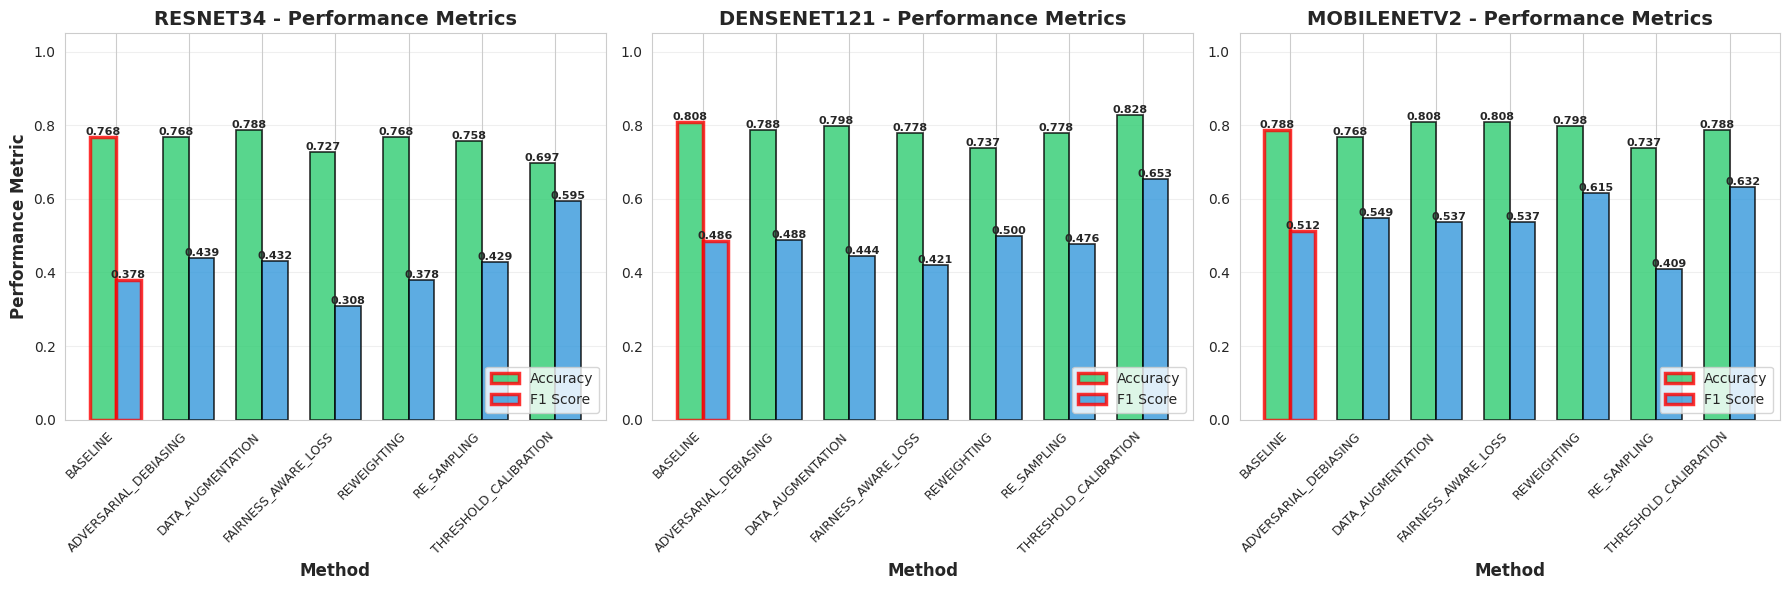

Saved: /content/drive/MyDrive/ELEC 509/Final Project/ddi_final_fairness_plots/fairness_metrics_by_model.png


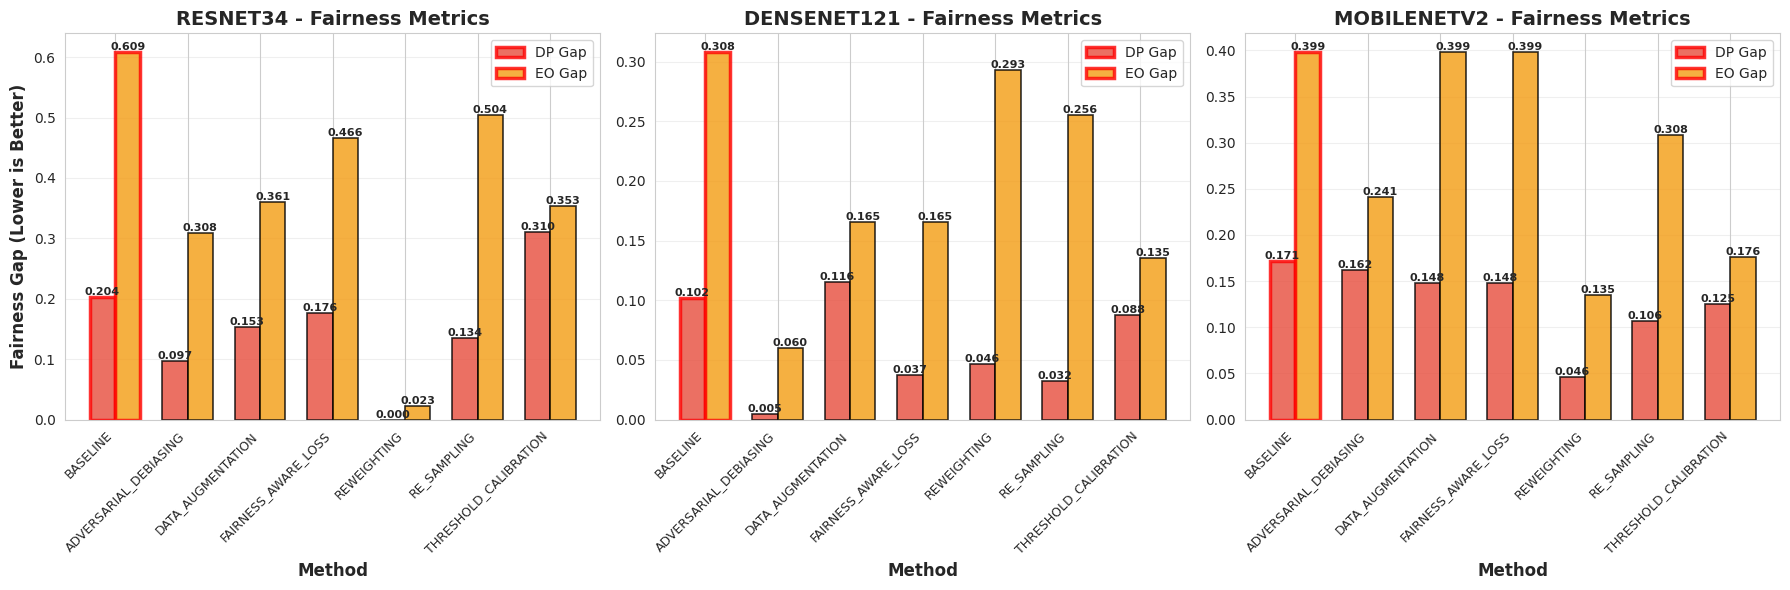

Saved: /content/drive/MyDrive/ELEC 509/Final Project/ddi_final_fairness_plots/statistical_significance_all.png


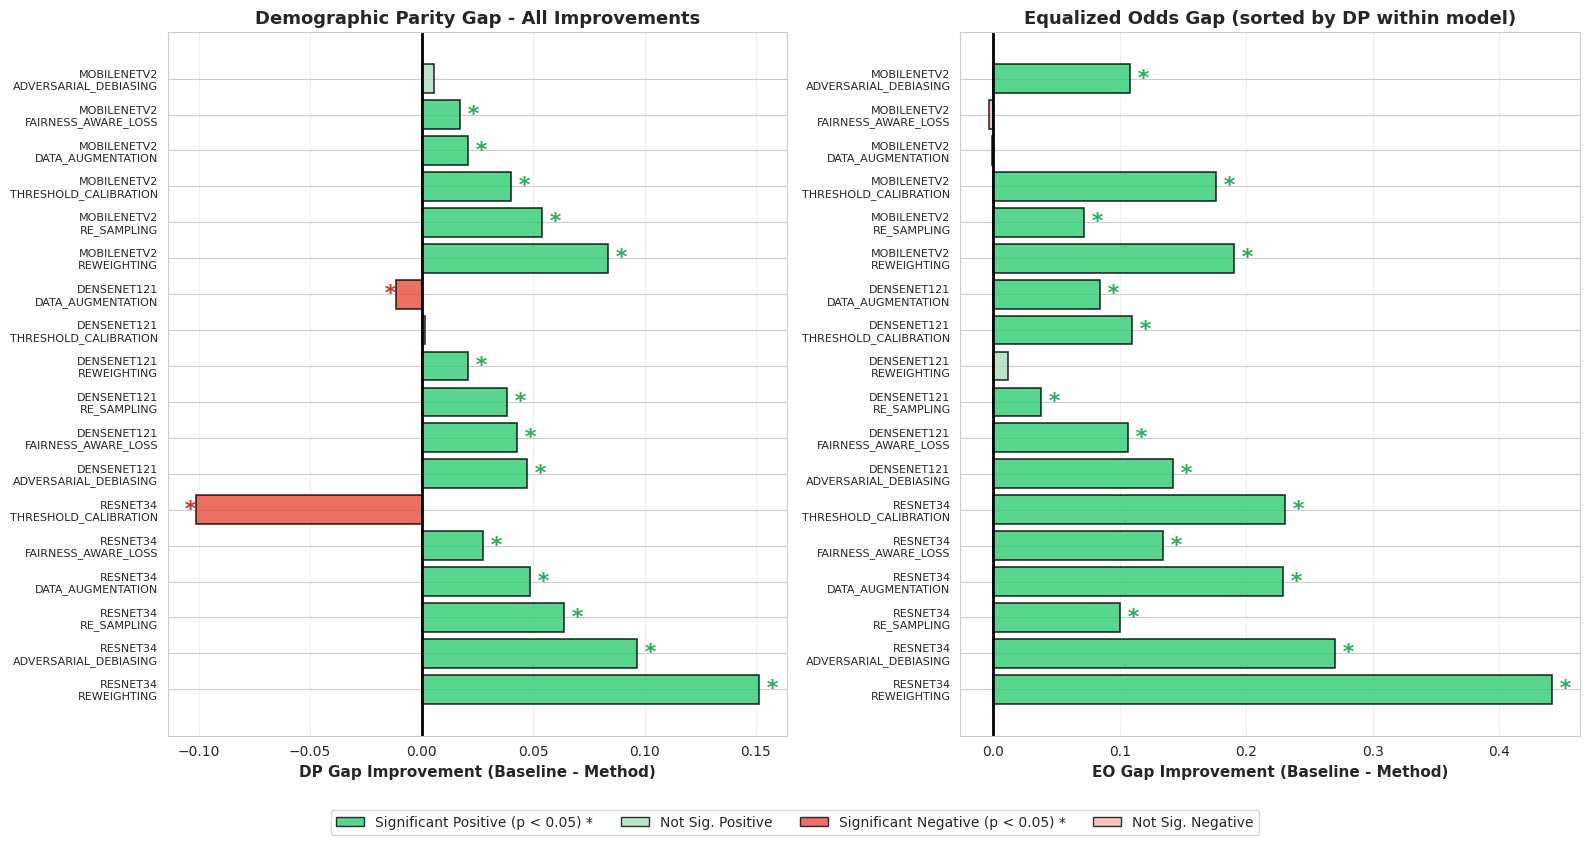

Saved: /content/drive/MyDrive/ELEC 509/Final Project/ddi_final_fairness_plots/statistical_significance_positive.png


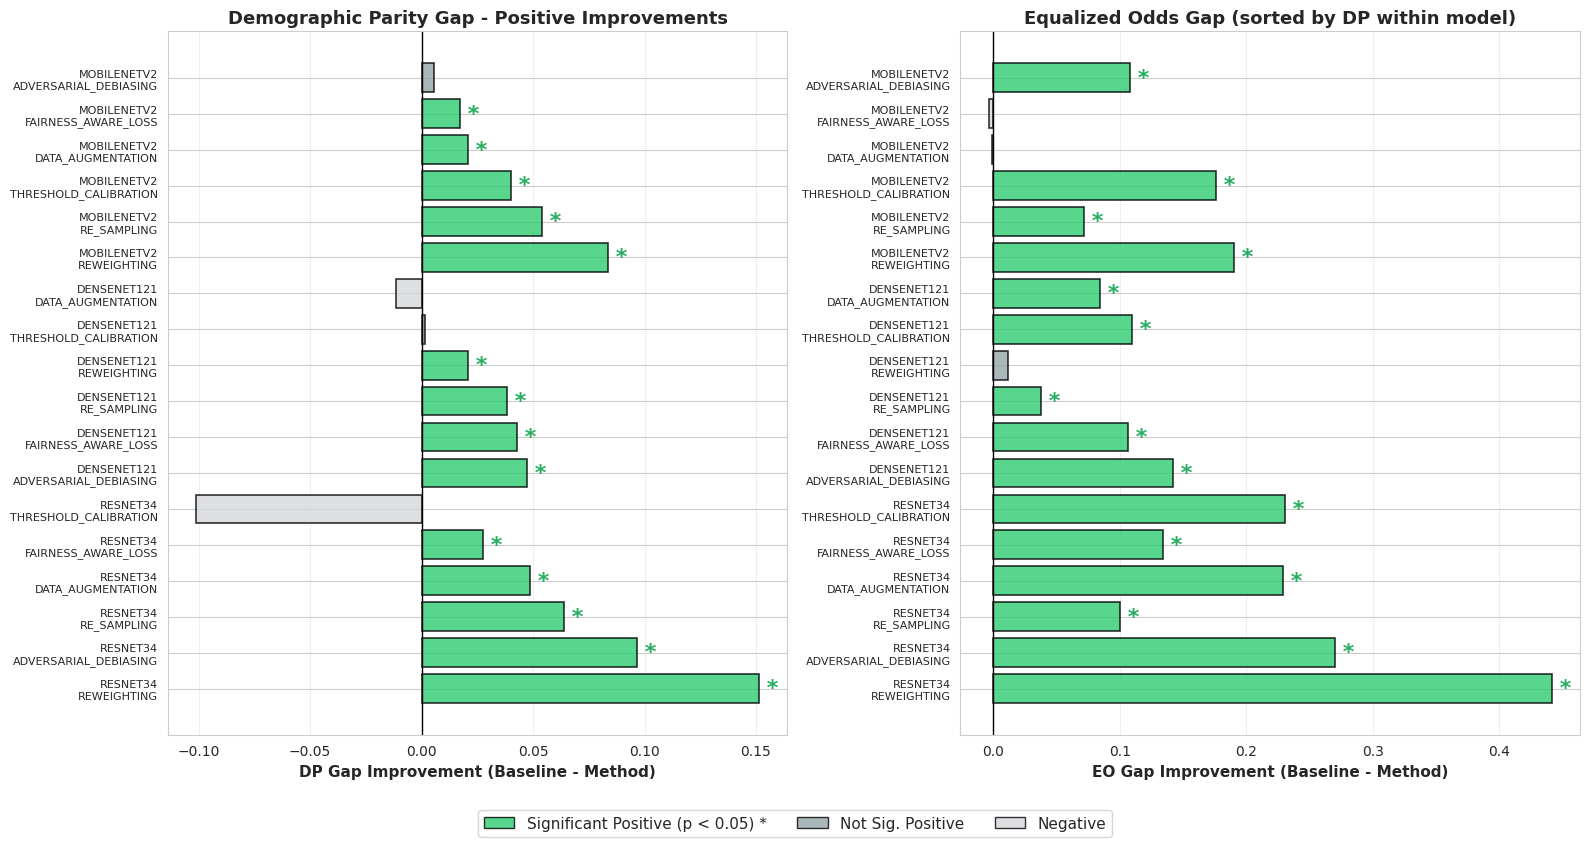

In [14]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


def create_output_folder(output_dir):
    """Create output directory if it doesn't exist"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")
    return output_dir


def load_results(results_file='fairness_comparison_results.csv'):
    """Load results from CSV"""
    df = pd.read_csv(results_file)
    return df


def create_accuracy_f1_by_model(df, filename, output_dir):
    """
    Create bar plot showing Accuracy and F1 Score together for each model
    """
    models = df['model'].unique()

    fig, axes = plt.subplots(1, len(models), figsize=(6*len(models), 6), sharey=False)

    if len(models) == 1:
        axes = [axes]

    # Colors for metrics
    metric_colors = {
        'accuracy': '#2ecc71',  # Green
        'f1': '#3498db',         # Blue
    }

    for idx, model in enumerate(models):
        ax = axes[idx]
        model_data = df[df['model'] == model].copy()

        # Sort methods with BASELINE first
        method_order = []
        if 'BASELINE' in model_data['method'].values:
            method_order.append('BASELINE')
        other_methods = sorted([m for m in model_data['method'].unique() if m != 'BASELINE'])
        method_order.extend(other_methods)

        # Reorder dataframe
        model_data['method'] = pd.Categorical(model_data['method'], categories=method_order, ordered=True)
        model_data = model_data.sort_values('method')

        methods_list = model_data['method'].values
        x_pos = np.arange(len(methods_list))
        width = 0.35  # Width of each bar

        # Plot grouped bars for accuracy and F1
        accuracy_vals = model_data['accuracy'].values
        f1_vals = model_data['f1'].values

        bars1 = ax.bar(x_pos - width/2, accuracy_vals, width,
                      label='Accuracy', color=metric_colors['accuracy'],
                      alpha=0.8, edgecolor='black', linewidth=1.2)

        bars2 = ax.bar(x_pos + width/2, f1_vals, width,
                      label='F1 Score', color=metric_colors['f1'],
                      alpha=0.8, edgecolor='black', linewidth=1.2)

        # Highlight baseline with thicker border
        if methods_list[0] == 'BASELINE':
            bars1[0].set_edgecolor('red')
            bars1[0].set_linewidth(2.5)
            bars2[0].set_edgecolor('red')
            bars2[0].set_linewidth(2.5)

        # Add value labels on bars
        for bar, val in zip(bars1, accuracy_vals):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.3f}',
                   ha='center', va='bottom', fontsize=8, fontweight='bold')

        for bar, val in zip(bars2, f1_vals):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.3f}',
                   ha='center', va='bottom', fontsize=8, fontweight='bold')

        # Formatting
        ax.set_xlabel('Method', fontsize=12, fontweight='bold')
        ax.set_ylabel('Performance Metric' if idx == 0 else '', fontsize=12, fontweight='bold')
        ax.set_title(f'{model.upper()} - Performance Metrics', fontsize=14, fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(methods_list, rotation=45, ha='right', fontsize=9)
        ax.grid(axis='y', alpha=0.3)
        ax.legend(loc='lower right', fontsize=10)

        # Set y-axis to show 0 to 1 range
        ax.set_ylim(0, 1.05)

    plt.tight_layout()
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")
    plt.show()
    plt.close()


def create_fairness_by_model(df, filename, output_dir):
    """
    Create bar plot showing DP Gap and EO Gap together for each model
    """
    models = df['model'].unique()

    fig, axes = plt.subplots(1, len(models), figsize=(6*len(models), 6), sharey=False)

    if len(models) == 1:
        axes = [axes]

    # Colors for fairness metrics
    metric_colors = {
        'dp_gap': '#e74c3c',     # Red
        'eo_gap': '#f39c12'      # Orange
    }

    for idx, model in enumerate(models):
        ax = axes[idx]
        model_data = df[df['model'] == model].copy()

        # Sort methods with BASELINE first
        method_order = []
        if 'BASELINE' in model_data['method'].values:
            method_order.append('BASELINE')
        other_methods = sorted([m for m in model_data['method'].unique() if m != 'BASELINE'])
        method_order.extend(other_methods)

        # Reorder dataframe
        model_data['method'] = pd.Categorical(model_data['method'], categories=method_order, ordered=True)
        model_data = model_data.sort_values('method')

        methods_list = model_data['method'].values
        x_pos = np.arange(len(methods_list))
        width = 0.35  # Width of each bar

        # Plot grouped bars for DP and EO gaps
        dp_vals = model_data['dp_gap'].values
        eo_vals = model_data['eo_gap'].values

        bars1 = ax.bar(x_pos - width/2, dp_vals, width,
                      label='DP Gap', color=metric_colors['dp_gap'],
                      alpha=0.8, edgecolor='black', linewidth=1.2)

        bars2 = ax.bar(x_pos + width/2, eo_vals, width,
                      label='EO Gap', color=metric_colors['eo_gap'],
                      alpha=0.8, edgecolor='black', linewidth=1.2)

        # Highlight baseline with thicker border
        if methods_list[0] == 'BASELINE':
            bars1[0].set_edgecolor('red')
            bars1[0].set_linewidth(2.5)
            bars2[0].set_edgecolor('red')
            bars2[0].set_linewidth(2.5)

        # Add value labels on bars
        for bar, val in zip(bars1, dp_vals):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.3f}',
                   ha='center', va='bottom', fontsize=8, fontweight='bold')

        for bar, val in zip(bars2, eo_vals):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.3f}',
                   ha='center', va='bottom', fontsize=8, fontweight='bold')

        # Formatting
        ax.set_xlabel('Method', fontsize=12, fontweight='bold')
        ax.set_ylabel('Fairness Gap (Lower is Better)' if idx == 0 else '', fontsize=12, fontweight='bold')
        ax.set_title(f'{model.upper()} - Fairness Metrics', fontsize=14, fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(methods_list, rotation=45, ha='right', fontsize=9)
        ax.grid(axis='y', alpha=0.3)
        ax.legend(loc='upper right', fontsize=10)

    plt.tight_layout()
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")
    plt.show()
    plt.close()


def create_statistical_significance_plot_all(stat_df, filename, output_dir):
    """
    Create visualization showing all statistical improvements (positive and negative)
    """
    models = stat_df['model'].unique()

    fig, axes = plt.subplots(1, 2, figsize=(16, max(8, len(models) * len(stat_df['method'].unique()) * 0.3)))


    all_labels = []
    all_rows = []

    for model in models:
        model_data = stat_df[stat_df['model'] == model].sort_values('dp_improvement', ascending=False)
        for _, row in model_data.iterrows():
            all_labels.append(f"{model.upper()}\n{row['method']}")
            all_rows.append(row)

    # DP Gap improvements
    ax1 = axes[0]
    improvement_data_dp = []
    colors_list_dp = []

    for row in all_rows:
        improvement_data_dp.append(row['dp_improvement'])

        # Color based on sign and significance
        if row['dp_improvement'] > 0:
            colors_list_dp.append('#2ecc71' if row['dp_significant'] else '#a9dfbf')  # Dark/light green
        else:
            colors_list_dp.append('#e74c3c' if row['dp_significant'] else '#f5b7b1')  # Dark/light red

    y_pos = np.arange(len(improvement_data_dp))
    bars = ax1.barh(y_pos, improvement_data_dp, color=colors_list_dp, alpha=0.8, edgecolor='black', linewidth=1.2)

    # Add significance markers
    for i, (bar, row) in enumerate(zip(bars, all_rows)):
        if row['dp_significant']:
            ax1.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                    ' *', ha='left' if row['dp_improvement'] > 0 else 'right',
                    va='center', fontsize=16, fontweight='bold',
                    color='#27ae60' if row['dp_improvement'] > 0 else '#c0392b')

    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(all_labels, fontsize=8)
    ax1.set_xlabel('DP Gap Improvement (Baseline - Method)', fontsize=11, fontweight='bold')
    ax1.set_title('Demographic Parity Gap - All Improvements', fontsize=13, fontweight='bold')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=2)
    ax1.grid(axis='x', alpha=0.3)

    ax2 = axes[1]
    improvement_data_eo = []
    colors_list_eo = []

    for row in all_rows:
        improvement_data_eo.append(row['eo_improvement'])

        # Color based on sign and significance
        if row['eo_improvement'] > 0:
            colors_list_eo.append('#2ecc71' if row['eo_significant'] else '#a9dfbf')  # Dark/light green
        else:
            colors_list_eo.append('#e74c3c' if row['eo_significant'] else '#f5b7b1')  # Dark/light red

    y_pos = np.arange(len(improvement_data_eo))
    bars = ax2.barh(y_pos, improvement_data_eo, color=colors_list_eo, alpha=0.8, edgecolor='black', linewidth=1.2)

    # Add significance markers
    for i, (bar, row) in enumerate(zip(bars, all_rows)):
        if row['eo_significant']:
            ax2.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                    ' *', ha='left' if row['eo_improvement'] > 0 else 'right',
                    va='center', fontsize=16, fontweight='bold',
                    color='#27ae60' if row['eo_improvement'] > 0 else '#c0392b')

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(all_labels, fontsize=8)
    ax2.set_xlabel('EO Gap Improvement (Baseline - Method)', fontsize=11, fontweight='bold')
    ax2.set_title('Equalized Odds Gap (sorted by DP within model)', fontsize=13, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=2)
    ax2.grid(axis='x', alpha=0.3)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2ecc71', alpha=0.8, edgecolor='black', label='Significant Positive (p < 0.05) *'),
        Patch(facecolor='#a9dfbf', alpha=0.8, edgecolor='black', label='Not Sig. Positive'),
        Patch(facecolor='#e74c3c', alpha=0.8, edgecolor='black', label='Significant Negative (p < 0.05) *'),
        Patch(facecolor='#f5b7b1', alpha=0.8, edgecolor='black', label='Not Sig. Negative')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.01),
              ncol=4, fontsize=10)

    plt.tight_layout()
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")
    plt.show()
    plt.close()


def create_statistical_significance_plot_positive(stat_df, filename, output_dir):
    """
    Create visualization showing ONLY POSITIVE statistical improvements
    """
    models = stat_df['model'].unique()

    fig, axes = plt.subplots(1, 2, figsize=(16, max(8, len(models) * len(stat_df['method'].unique()) * 0.3)))

    all_labels = []
    all_rows = []

    for model in models:
        model_data = stat_df[stat_df['model'] == model].sort_values('dp_improvement', ascending=False)
        # Filter to keep only rows with at least one positive improvement
        model_data_filtered = model_data[(model_data['dp_improvement'] > 0) | (model_data['eo_improvement'] > 0)]
        for _, row in model_data_filtered.iterrows():
            all_labels.append(f"{model.upper()}\n{row['method']}")
            all_rows.append(row)

    ax1 = axes[0]
    improvement_data_dp = []
    colors_list_dp = []

    for row in all_rows:
        improvement_data_dp.append(row['dp_improvement'])

        # Color: green if significant positive, gray if not significant positive, light gray if negative
        if row['dp_improvement'] > 0:
            colors_list_dp.append('#2ecc71' if row['dp_significant'] else '#95a5a6')
        else:
            colors_list_dp.append('#d5d8dc')

    if len(improvement_data_dp) > 0:
        y_pos = np.arange(len(improvement_data_dp))
        bars = ax1.barh(y_pos, improvement_data_dp, color=colors_list_dp, alpha=0.8, edgecolor='black', linewidth=1.2)

        # Add significance markers for significant positive improvements
        for i, (bar, row) in enumerate(zip(bars, all_rows)):
            if row['dp_significant'] and row['dp_improvement'] > 0:
                ax1.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                        ' *', ha='left', va='center', fontsize=16, fontweight='bold', color='#27ae60')

        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(all_labels, fontsize=8)
        ax1.set_xlabel('DP Gap Improvement (Baseline - Method)', fontsize=11, fontweight='bold')
        ax1.set_title('Demographic Parity Gap - Positive Improvements', fontsize=13, fontweight='bold')
        ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
        ax1.grid(axis='x', alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'No positive improvements',
                ha='center', va='center', fontsize=14, transform=ax1.transAxes)
        ax1.set_xlabel('DP Gap Improvement (Baseline - Method)', fontsize=11, fontweight='bold')
        ax1.set_title('Demographic Parity Gap - Positive Improvements', fontsize=13, fontweight='bold')


    ax2 = axes[1]
    improvement_data_eo = []
    colors_list_eo = []

    for row in all_rows:
        improvement_data_eo.append(row['eo_improvement'])

        # Color: green if significant positive, gray if not significant positive, light gray if negative
        if row['eo_improvement'] > 0:
            colors_list_eo.append('#2ecc71' if row['eo_significant'] else '#95a5a6')
        else:
            colors_list_eo.append('#d5d8dc')  # Very light gray for negative (alignment only)

    if len(improvement_data_eo) > 0:
        y_pos = np.arange(len(improvement_data_eo))
        bars = ax2.barh(y_pos, improvement_data_eo, color=colors_list_eo, alpha=0.8, edgecolor='black', linewidth=1.2)

        # Add significance markers for significant positive improvements
        for i, (bar, row) in enumerate(zip(bars, all_rows)):
            if row['eo_significant'] and row['eo_improvement'] > 0:
                ax2.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                        ' *', ha='left', va='center', fontsize=16, fontweight='bold', color='#27ae60')

        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(all_labels, fontsize=8)
        ax2.set_xlabel('EO Gap Improvement (Baseline - Method)', fontsize=11, fontweight='bold')
        ax2.set_title('Equalized Odds Gap (sorted by DP within model)', fontsize=13, fontweight='bold')
        ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
        ax2.grid(axis='x', alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No positive improvements',
                ha='center', va='center', fontsize=14, transform=ax2.transAxes)
        ax2.set_xlabel('EO Gap Improvement (Baseline - Method)', fontsize=11, fontweight='bold')
        ax2.set_title('Equalized Odds Gap (sorted by DP within model)', fontsize=13, fontweight='bold')

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2ecc71', alpha=0.8, edgecolor='black', label='Significant Positive (p < 0.05) *'),
        Patch(facecolor='#95a5a6', alpha=0.8, edgecolor='black', label='Not Sig. Positive'),
        Patch(facecolor='#d5d8dc', alpha=0.8, edgecolor='black', label='Negative')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.01),
              ncol=3, fontsize=11)

    plt.tight_layout()
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")
    plt.show()
    plt.close()


def main():
    OUTPUT_DIR = '/content/drive/MyDrive/ELEC 509/Final Project/ddi_final_fairness_plots'
    RESULTS_FILE = '/content/drive/MyDrive/ELEC 509/Final Project/ddi_fairness_comparison_results_ddi.csv'
    STATS_FILE = '/content/drive/MyDrive/ELEC 509/Final Project/ddi_statistical_comparison_results_ddi.csv'


    # Create output directory
    output_dir = create_output_folder(OUTPUT_DIR)

    # Load data
    results_df = load_results(RESULTS_FILE)

    try:
        stat_df = pd.read_csv(STATS_FILE)
        has_stats = True
    except:
        has_stats = False

    print(f"Loaded data for {len(results_df['model'].unique())} models")
    print(f"Models: {', '.join([m.upper() for m in results_df['model'].unique()])}")
    print(f"Methods: {len(results_df['method'].unique())}")

    # 1. Performance metrics (Accuracy + F1) per model
    create_accuracy_f1_by_model(results_df, 'performance_metrics_by_model.png', output_dir)

    # 2. Fairness metrics (DP Gap + EO Gap) per model
    create_fairness_by_model(results_df, 'fairness_metrics_by_model.png', output_dir)

    # 3. Statistical significance plot: all improvements
    if has_stats:
        create_statistical_significance_plot_all(stat_df, 'statistical_significance_all.png', output_dir)

    # 4. Statistical significance plot: positive only
    if has_stats:
        create_statistical_significance_plot_positive(stat_df, 'statistical_significance_positive.png', output_dir)



if __name__ == "__main__":
    main()